In [1]:
import tensorflow as tf
import numpy as np
from netCDF4 import Dataset

In [33]:
#Parameter List
parameter_list = {}

parameter_list['netCDf_loc'] = "./lorenz96_multi/DATA_sample/X40F18/all_10/nocorr_I20/assim.nc"
parameter_list['locality'] = 5
parameter_list['time_splits'] = 30
parameter_list['batch_size'] = 240
parameter_list['val_size'] = 2
parameter_list['LSTM_output'] = 5
parameter_list['net_output'] = 1

In [3]:
#Getting the NetCDF files
root_grp = Dataset(parameter_list['netCDf_loc'], "r", format="NETCDF4")

#Extrating the datasets
analysis_init = root_grp["vam"]
forecast_init = root_grp["vfm"]

In [13]:
#Creation of datasets for training and validation

#For creating locality for individual state variable
def locality_creator(init_dataset):
    
    output_dataset = np.zeros((init_dataset.shape[0], init_dataset.shape[1], parameter_list['locality']))
    radius = int(parameter_list['locality'] / 2)
    
    for i in range(init_dataset.shape[1]):
        start = i - radius
        stop = i + radius
        index = np.linspace(start,stop,parameter_list['locality'], dtype='int')
        if stop >= init_dataset.shape[1]:
            stop2 = (stop + 1)%init_dataset.shape[1]
            index[:-stop2] = np.linspace(start,analysis_init.shape[1]-1,analysis_init.shape[1]-start, dtype='int')
            index[-stop2:] = np.arange(0,stop2,1,dtype='int')
        output_dataset[:,i,:] = init_dataset[:,index]

    return np.transpose(output_dataset,(1,0,2)).astype('float32')

#For creating the truth label
def truth_label_creator(init_dataset):
    output_dataset = init_dataset[:]
    output_dataset = np.expand_dims(output_dataset, axis=0)
    return np.transpose(output_dataset.astype('float32'))

analysis_dataset = truth_label_creator(analysis_init)
forecast_dataset = locality_creator(forecast_init)

In [16]:
print(analysis_dataset.shape)
print(forecast_dataset.shape)

(40, 7200, 1)
(40, 7200, 5)


In [17]:
#Creating time data splits
def split_sequences(sequences, n_steps):
    X = list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i*n_steps + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i*n_steps:end_ix, :]
        X.append(seq_x)
    return np.array(X)

In [18]:
#For serializing the tensor to a string for TFRecord
def _serialize_tensor(value):
    return tf.io.serialize_tensor(value)

In [19]:
#For writing data to the TFRecord file
def write_TFRecord(filename, dataset):
    with tf.io.TFRecordWriter(filename) as writer:
        for i in range(dataset.shape[0]):
            dataset_splits = split_sequences(dataset[i],parameter_list['time_splits'])
            for j in range(dataset_splits.shape[0]):
                data = dataset_splits[j]
                serial_string = _serialize_tensor(data)
                writer.write(serial_string.numpy())
    writer.close()

In [20]:
#For reading the TFRecord File
def read_TFRecord(filename):
    return tf.data.TFRecordDataset(filename)

#For parsing the value from string to float32
def _parse_tensor(value):
    return tf.io.parse_tensor(value, out_type=tf.float32)

In [21]:
write_TFRecord('analysis.tfrecord', analysis_dataset)
write_TFRecord('forecast.tfrecord', forecast_dataset)

In [22]:
#Reading the TFRecord files
anal_file = read_TFRecord('analysis.tfrecord')
fore_file = read_TFRecord('forecast.tfrecord')

#Parsing the dataset
anal_file = anal_file.map(_parse_tensor)
fore_file = fore_file.map(_parse_tensor)

In [26]:
for i in anal_file.take(2):
    print(i)

tf.Tensor(
[[ 2.5275862 ]
 [ 0.10720196]
 [-4.5038705 ]
 [-0.5758473 ]
 [ 4.96911   ]
 [ 9.766104  ]
 [12.0870075 ]
 [12.366183  ]
 [11.989755  ]
 [11.572255  ]
 [ 9.129641  ]
 [ 7.2429566 ]
 [ 5.590367  ]
 [ 3.9402463 ]
 [ 1.6291242 ]
 [-0.04845555]
 [-1.2606804 ]
 [-1.285853  ]
 [-1.9424187 ]
 [-1.1521606 ]
 [ 1.0832406 ]
 [ 1.0983195 ]
 [ 1.6302749 ]
 [ 3.073546  ]
 [ 5.539774  ]
 [ 8.607784  ]
 [10.845199  ]
 [12.17369   ]
 [12.109179  ]
 [12.031685  ]], shape=(30, 1), dtype=float32)
tf.Tensor(
[[12.206066  ]
 [11.010676  ]
 [ 9.625998  ]
 [ 8.224021  ]
 [ 4.4870877 ]
 [ 1.8564718 ]
 [-2.012524  ]
 [-4.3671155 ]
 [-5.4911284 ]
 [-3.0116932 ]
 [ 0.8351451 ]
 [ 3.1534274 ]
 [ 3.2474718 ]
 [ 2.3837285 ]
 [ 2.3529098 ]
 [ 2.8351338 ]
 [ 3.5794053 ]
 [ 3.6161501 ]
 [ 6.0409837 ]
 [ 6.8243957 ]
 [ 7.637682  ]
 [ 7.6558876 ]
 [ 3.9638317 ]
 [-0.31291604]
 [-3.6446133 ]
 [-5.5014067 ]
 [-5.731505  ]
 [-4.3057094 ]
 [-3.1555994 ]
 [-2.1563272 ]], shape=(30, 1), dtype=float32)


In [27]:
#Zipping the files
dataset = tf.data.Dataset.zip((fore_file, anal_file))

#Shuffling the dataset
dataset = dataset.shuffle(100000)
dataset = dataset.batch(batch_size=parameter_list['batch_size'])

In [32]:
for i,j in train_dataset.take(1):
    print(i)
    print(j)

tf.Tensor(
[[[-5.5598254  -2.1059184   0.41211593  8.918329    7.2337728 ]
  [-5.4811873  -0.597272    0.9582342  10.14994     4.1737823 ]
  [-3.510908   -0.33660686  1.4144015  10.18889     0.9562744 ]
  ...
  [ 1.3940802  -0.48760372  3.1480527  11.7588625  12.928122  ]
  [-1.8986384   0.30543423  3.1541739  13.49599    11.8989525 ]
  [-1.0812358   0.826409    4.4172773  15.013823    5.528044  ]]

 [[ 2.529325   -0.82746166  2.375769    7.5910177  11.007996  ]
  [ 4.844715    1.3695284   3.4272459   9.853755    8.039642  ]
  [ 6.2216773   3.0345786   4.167145   10.4467      2.8360262 ]
  ...
  [-1.5589371   0.01981308  3.569725   11.728434   -4.2556243 ]
  [-0.790359    0.8839122   5.360207   10.49557    -3.6153824 ]
  [ 0.5827171   1.803542    6.390567    8.940467   -2.455832  ]]

 [[-5.287018    5.995021    6.748928    4.244227    6.9680014 ]
  [-4.1884236   5.7011933   9.229808    4.8082504   6.7187877 ]
  [-3.1932144   4.1940794  11.3814335   5.9808016   5.763995  ]
  ...
  [ 4.3

In [30]:
#For creating Train and Validation datasets
def train_val_creator(dataset, val_size):
    val_dataset = dataset.take(val_size)
    train_dataset = dataset.skip(val_size)
    return train_dataset, val_dataset

In [31]:
train_dataset, val_dataset = train_val_creator(dataset, parameter_list['val_size'])

In [36]:
#Model defination
def rnn_model():
    net_input = tf.keras.Input(shape=(parameter_list['time_splits'], parameter_list['locality']), name='INPUT')
    x = tf.keras.layers.LSTM(units=parameter_list['LSTM_output'])(net_input)
    output = tf.keras.layers.Dense(units=parameter_list['net_output'], activation=tf.keras.activations.relu)(x)
    return tf.keras.Model(net_input, output, name='RNN')

In [37]:
model = rnn_model()

In [38]:
model.summary()

Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 30, 5)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


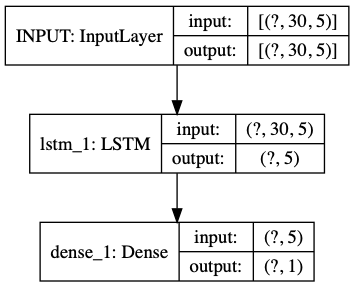

In [39]:
tf.keras.utils.plot_model(model, show_shapes=True)